In [1]:
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import LabelEncoder
from scipy.stats import friedmanchisquare
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix

In [2]:
base_path = 'homeworks/data/project/gesture_phase/'

In [3]:
df = pd.read_csv(base_path + 'gesture_phase.csv')

In [4]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,Phase
0,-0.000010,-0.000021,0.000005,-0.000006,0.000043,-0.000011,0.000004,-0.000027,0.000006,-0.000029,...,-1.770000e-06,0.000024,0.000045,0.000028,0.000084,0.000003,0.000010,0.000004,0.000015,D
1,-0.000006,-0.000017,0.000004,-0.000020,0.000064,-0.000010,0.000008,-0.000023,0.000005,-0.000045,...,-1.770000e-06,0.000019,0.000068,0.000025,0.000154,0.000002,0.000008,0.000002,0.000021,D
2,-0.000025,-0.000026,0.000004,-0.000027,0.000061,-0.000008,-0.000005,-0.000030,0.000007,-0.000053,...,9.100000e-07,0.000036,0.000067,0.000031,0.000154,0.000006,0.000003,0.000005,0.000003,D
3,-0.000041,-0.000037,0.000005,-0.000033,0.000060,-0.000006,-0.000020,-0.000038,0.000009,-0.000051,...,1.660000e-06,0.000055,0.000069,0.000044,0.000127,0.000006,0.000002,0.000005,0.000008,D
4,-0.000052,-0.000046,0.000005,-0.000030,0.000044,-0.000004,-0.000029,-0.000045,0.000010,-0.000039,...,2.100000e-06,0.000069,0.000054,0.000054,0.000068,0.000004,0.000005,0.000003,0.000018,D


In [31]:
## df values to numpy array
X = df.values[:, :-1]
y_target = df.values[:, -1]
labels = np.unique(y_target)

# Initialize the LabelEncoder
le = LabelEncoder()
# Fit and transform the data to the label encoder
y = le.fit_transform(y_target)

In [6]:
## Split into train and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 2:Train and validation data  70% train y 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)


In [12]:
## Define the search space for the hyperparameter tuning with hyperopt
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 4000, 1),
    'eta': hp.loguniform('eta', np.log(1e-7), np.log(1)),  # Usando np.log para el rango
    'max_depth': hp.quniform('max_depth', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.2, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 1),
    'min_child_weight': hp.loguniform('min_child_weight', np.log(1e-16), np.log(1e5)),
    'alpha': hp.choice('alpha', [0, hp.loguniform('alpha_loguniform', np.log(1e-16), np.log(1e2))]),
    'lambda': hp.choice('lambda', [0, hp.loguniform('lambda_loguniform', np.log(1e-16), np.log(1e2))]),
    'gamma': hp.choice('gamma', [0, hp.loguniform('gamma_loguniform', np.log(1e-16), np.log(1e2))])
}

In [21]:
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    model = xgb.XGBClassifier(**params, objective='multi:softprob')  # Ajusta el objetivo según tu problema
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10)
    y_prob = model.predict_proba(X_test)
    loss = log_loss(y_test, y_prob)
   
    return {'loss': loss, 'status': STATUS_OK}
    

# Optimización
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

[0]	validation_0-mlogloss:1.60944                     
[1]	validation_0-mlogloss:1.60944                     
[2]	validation_0-mlogloss:1.60944                     
[3]	validation_0-mlogloss:1.60944                     
[4]	validation_0-mlogloss:1.60943                     
[5]	validation_0-mlogloss:1.60943                     
[6]	validation_0-mlogloss:1.60943                     
[7]	validation_0-mlogloss:1.60943                     
[8]	validation_0-mlogloss:1.60943                     
[9]	validation_0-mlogloss:1.60943                     
[10]	validation_0-mlogloss:1.60943                    
[11]	validation_0-mlogloss:1.60943                    
[12]	validation_0-mlogloss:1.60943                    
[13]	validation_0-mlogloss:1.60943                    
[14]	validation_0-mlogloss:1.60943                    
[15]	validation_0-mlogloss:1.60943                    
[16]	validation_0-mlogloss:1.60943                    
[17]	validation_0-mlogloss:1.60943                    
[18]	valid

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[23]	validation_0-mlogloss:1.60942                    
[24]	validation_0-mlogloss:1.60942                    
[25]	validation_0-mlogloss:1.60942                    
[26]	validation_0-mlogloss:1.60942                    
[27]	validation_0-mlogloss:1.60942                    
[28]	validation_0-mlogloss:1.60942                    
[29]	validation_0-mlogloss:1.60942                    
[30]	validation_0-mlogloss:1.60942                    
[31]	validation_0-mlogloss:1.60942                    
[32]	validation_0-mlogloss:1.60942                    
[33]	validation_0-mlogloss:1.60942                    
[34]	validation_0-mlogloss:1.60942                    
[35]	validation_0-mlogloss:1.60942                    
[36]	validation_0-mlogloss:1.60942                    
[37]	validation_0-mlogloss:1.60942                    
[38]	validation_0-mlogloss:1.60941                    
[39]	validation_0-mlogloss:1.60941                    
[40]	validation_0-mlogloss:1.60941                    
[41]	valid

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[7]	validation_0-mlogloss:1.60941                                              
[8]	validation_0-mlogloss:1.60941                                              
[9]	validation_0-mlogloss:1.60941                                              
[10]	validation_0-mlogloss:1.60940                                             
[11]	validation_0-mlogloss:1.60940                                             
[12]	validation_0-mlogloss:1.60940                                             
[13]	validation_0-mlogloss:1.60939                                             
[14]	validation_0-mlogloss:1.60939                                             
[15]	validation_0-mlogloss:1.60939                                             
[16]	validation_0-mlogloss:1.60938                                             
[17]	validation_0-mlogloss:1.60938                                             
[18]	validation_0-mlogloss:1.60938                                             
[19]	validation_0-mlogloss:1.60937      

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[15]	validation_0-mlogloss:1.60238                                              
[16]	validation_0-mlogloss:1.60195                                              
[17]	validation_0-mlogloss:1.60152                                              
[18]	validation_0-mlogloss:1.60109                                              
[19]	validation_0-mlogloss:1.60064                                              
[20]	validation_0-mlogloss:1.60020                                              
[21]	validation_0-mlogloss:1.59976                                              
[22]	validation_0-mlogloss:1.59933                                              
[23]	validation_0-mlogloss:1.59890                                              
[24]	validation_0-mlogloss:1.59844                                              
[25]	validation_0-mlogloss:1.59800                                              
[26]	validation_0-mlogloss:1.59758                                              
[27]	validation_0-mlogloss:1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[41]	validation_0-mlogloss:1.60943                                              
[42]	validation_0-mlogloss:1.60943                                              
[43]	validation_0-mlogloss:1.60943                                              
[44]	validation_0-mlogloss:1.60943                                              
[45]	validation_0-mlogloss:1.60943                                              
[46]	validation_0-mlogloss:1.60943                                              
[47]	validation_0-mlogloss:1.60943                                              
[48]	validation_0-mlogloss:1.60943                                              
[49]	validation_0-mlogloss:1.60943                                              
[50]	validation_0-mlogloss:1.60943                                              
[51]	validation_0-mlogloss:1.60943                                              
[52]	validation_0-mlogloss:1.60943                                              
[53]	validation_0-mlogloss:1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[9]	validation_0-mlogloss:1.15997                                               
[10]	validation_0-mlogloss:1.14929                                              
[11]	validation_0-mlogloss:1.14094                                              
[12]	validation_0-mlogloss:1.13300                                              
[13]	validation_0-mlogloss:1.12430                                              
[14]	validation_0-mlogloss:1.12038                                              
[15]	validation_0-mlogloss:1.11568                                              
[16]	validation_0-mlogloss:1.11158                                              
[17]	validation_0-mlogloss:1.10870                                              
[18]	validation_0-mlogloss:1.09869                                              
[19]	validation_0-mlogloss:1.09464                                              
[20]	validation_0-mlogloss:1.09035                                              
[21]	validation_0-mlogloss:1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[16]	validation_0-mlogloss:1.60944                                             
[17]	validation_0-mlogloss:1.60944                                             
[18]	validation_0-mlogloss:1.60944                                             
[19]	validation_0-mlogloss:1.60944                                             
[20]	validation_0-mlogloss:1.60944                                             
[21]	validation_0-mlogloss:1.60944                                             
[22]	validation_0-mlogloss:1.60944                                             
[23]	validation_0-mlogloss:1.60944                                             
[24]	validation_0-mlogloss:1.60944                                             
[25]	validation_0-mlogloss:1.60944                                             
[26]	validation_0-mlogloss:1.60944                                             
[27]	validation_0-mlogloss:1.60944                                             
[28]	validation_0-mlogloss:1.60944      

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3]	validation_0-mlogloss:1.57243                                              
[4]	validation_0-mlogloss:1.56361                                              
[5]	validation_0-mlogloss:1.55564                                              
[6]	validation_0-mlogloss:1.54700                                              
[7]	validation_0-mlogloss:1.53888                                              
[8]	validation_0-mlogloss:1.53046                                              
[9]	validation_0-mlogloss:1.52315                                              
[10]	validation_0-mlogloss:1.51520                                             
[11]	validation_0-mlogloss:1.50755                                             
[12]	validation_0-mlogloss:1.50027                                             
[13]	validation_0-mlogloss:1.49284                                             
[14]	validation_0-mlogloss:1.48593                                             
[15]	validation_0-mlogloss:1.47895      

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[5]	validation_0-mlogloss:1.60927                                               
[6]	validation_0-mlogloss:1.60924                                               
[7]	validation_0-mlogloss:1.60921                                               
[8]	validation_0-mlogloss:1.60919                                               
[9]	validation_0-mlogloss:1.60916                                               
[10]	validation_0-mlogloss:1.60913                                              
[11]	validation_0-mlogloss:1.60910                                              
[12]	validation_0-mlogloss:1.60907                                              
[13]	validation_0-mlogloss:1.60905                                              
[14]	validation_0-mlogloss:1.60902                                              
[15]	validation_0-mlogloss:1.60899                                              
[16]	validation_0-mlogloss:1.60896                                              
[17]	validation_0-mlogloss:1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[2]	validation_0-mlogloss:1.57625                                               
[3]	validation_0-mlogloss:1.56614                                               
[4]	validation_0-mlogloss:1.55626                                               
[5]	validation_0-mlogloss:1.54626                                               
[6]	validation_0-mlogloss:1.53694                                               
[7]	validation_0-mlogloss:1.52805                                               
[8]	validation_0-mlogloss:1.51872                                               
[9]	validation_0-mlogloss:1.50937                                               
[10]	validation_0-mlogloss:1.50061                                              
[11]	validation_0-mlogloss:1.49213                                              
[12]	validation_0-mlogloss:1.48355                                              
[13]	validation_0-mlogloss:1.47569                                              
[14]	validation_0-mlogloss:1

In [22]:
print(best)

{'alpha': 0, 'colsample_bylevel': 0.9433908286909145, 'colsample_bytree': 0.971508164246875, 'eta': 0.01441782062648658, 'gamma': 0, 'lambda': 1, 'lambda_loguniform': 9.484018590168458e-10, 'max_depth': 8.0, 'min_child_weight': 4.7982415977839434e-08, 'n_estimators': 2046.0, 'subsample': 0.5291660190535432}


In [24]:
# Entrenar el modelo final con los mejores parámetros
best_params = space.copy()
best_params
for param, val in best.items():
    if param == 'max_depth' or param == 'n_estimators':
        best_params[param] = int(val)  # Convertir max_depth a int
    else:
        best_params[param] = val
best_model = xgb.XGBClassifier(**best_params, objective='multi:softprob')
best_model.fit(X_train, y_train)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:23:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "lambda_loguniform" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9433908286909145, colsample_bynode=None,
              colsample_bytree=0.971508164246875, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.01441782062648658, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1,
              lambda_loguniform=9.484018590168458e-10, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=4.7982415977839434e-08, missing=nan,
              monotone_constraints=None, multi_strategy=None, ...)

In [ ]:
best_model.save_model(base_path + 'best_model.json')


In [28]:
best_model.get_xgb_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': 0.9433908286909145,
 'colsample_bynode': None,
 'colsample_bytree': 0.971508164246875,
 'device': None,
 'eval_metric': None,
 'gamma': 0,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 8,
 'max_leaves': None,
 'min_child_weight': 4.7982415977839434e-08,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.5291660190535432,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.01441782062648658,
 'alpha': 0,
 'lambda': 1,
 'lambda_loguniform': 9.484018590168458e-10}

In [27]:
## evaluate the model
y_pred = best_model.predict(X_test)
print(trials.best_trial['result'])

{'loss': 0.8631188104333337, 'status': 'ok'}


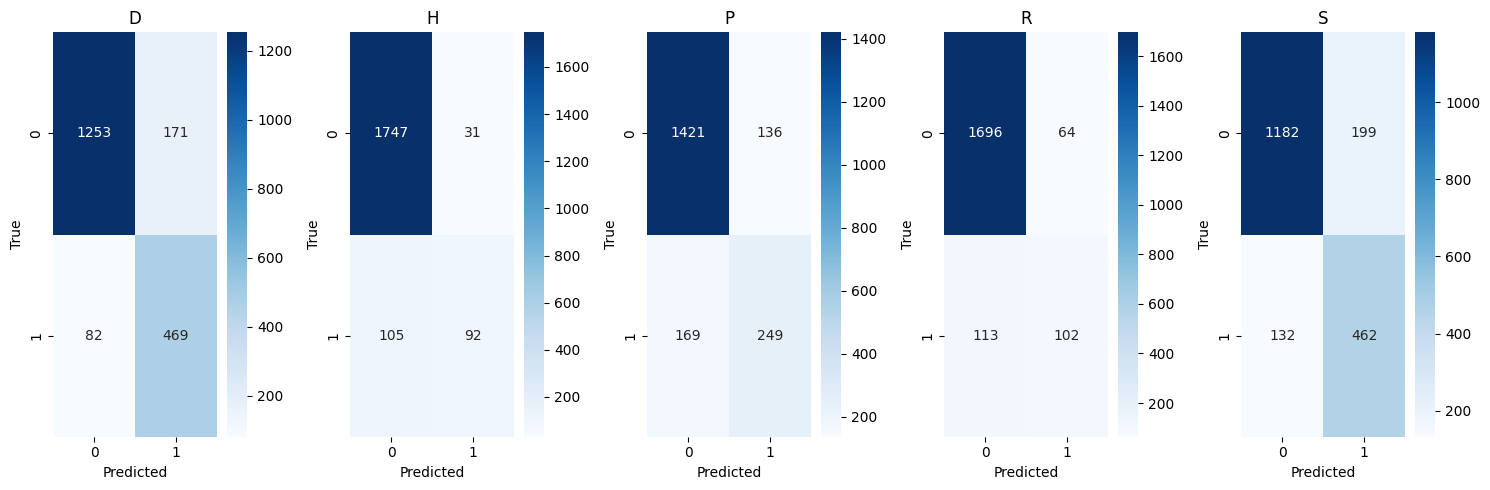

In [33]:
## confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de confusión multilabel
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Crear una figura y un conjunto de subtramas
fig, ax = plt.subplots(nrows=1, ncols=mcm.shape[0], figsize=(15, 5))

# Dibujar un mapa de calor para cada matriz de confusión
for axes, cm, label in zip(ax.flatten(), mcm, labels):
    sns.heatmap(cm, annot=True, fmt='d', ax=axes, cmap='Blues')
    axes.set_xlabel('Predicted')
    axes.set_ylabel('True')
    axes.set_title(label)

plt.tight_layout()
plt.savefig(base_path + 'confusion_matrix.png')
plt.show()

## Experiment with Shrutime (Two Class)



In [35]:
base_path = 'homeworks/data/project/'
df_shruntime = pd.read_csv(base_path + 'shrutime_encoded.csv')

In [36]:
X = df.values[:, :-1]
y_target = df.values[:, -1]

In [37]:
## Split into train and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 2:Train and validation data  70% train y 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)


In [46]:
## Optimization hyperparameters
def objectiveBinary(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    model = xgb.XGBClassifier(**params, objective='binary:logistic')  # Ajusta el objetivo según tu problema
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10)
    y_prob = model.predict_proba(X_test)
    loss = log_loss(y_test, y_prob)
    #print('Loss:', loss)
    return {'loss': loss, 'status': STATUS_OK}
trials = Trials()
best = fmin(objectiveBinary, space, algo=tpe.suggest, max_evals=10, trials=trials, verbose=0)


[0]	validation_0-mlogloss:1.60944
[1]	validation_0-mlogloss:1.60944
[2]	validation_0-mlogloss:1.60944
[3]	validation_0-mlogloss:1.60944
[4]	validation_0-mlogloss:1.60944
[5]	validation_0-mlogloss:1.60944
[6]	validation_0-mlogloss:1.60944
[7]	validation_0-mlogloss:1.60944


[8]	validation_0-mlogloss:1.60944
[9]	validation_0-mlogloss:1.60944


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.60881
[1]	validation_0-mlogloss:1.60818
[2]	validation_0-mlogloss:1.60761
[3]	validation_0-mlogloss:1.60701
[4]	validation_0-mlogloss:1.60639
[5]	validation_0-mlogloss:1.60575
[6]	validation_0-mlogloss:1.60515
[7]	validation_0-mlogloss:1.60454
[8]	validation_0-mlogloss:1.60401
[9]	validation_0-mlogloss:1.60340
[10]	validation_0-mlogloss:1.60282
[11]	validation_0-mlogloss:1.60227
[12]	validation_0-mlogloss:1.60168
[13]	validation_0-mlogloss:1.60111
[14]	validation_0-mlogloss:1.60053
[15]	validation_0-mlogloss:1.59993
[16]	validation_0-mlogloss:1.59938
[17]	validation_0-mlogloss:1.59881
[18]	validation_0-mlogloss:1.59828
[19]	validation_0-mlogloss:1.59768
[20]	validation_0-mlogloss:1.59709
[21]	validation_0-mlogloss:1.59657
[22]	validation_0-mlogloss:1.59600
[23]	validation_0-mlogloss:1.59543
[24]	validation_0-mlogloss:1.59485
[25]	validation_0-mlogloss:1.59428
[26]	validation_0-mlogloss:1.59371
[27]	validation_0-mlogloss:1.59315
[28]	validation_0-mlogloss:1.5

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.41390
[2]	validation_0-mlogloss:1.35204
[3]	validation_0-mlogloss:1.30644
[4]	validation_0-mlogloss:1.26541
[5]	validation_0-mlogloss:1.23611
[6]	validation_0-mlogloss:1.20985
[7]	validation_0-mlogloss:1.18627
[8]	validation_0-mlogloss:1.16744
[9]	validation_0-mlogloss:1.14927
[10]	validation_0-mlogloss:1.13766
[11]	validation_0-mlogloss:1.12650
[12]	validation_0-mlogloss:1.11567
[13]	validation_0-mlogloss:1.10747
[14]	validation_0-mlogloss:1.09719
[15]	validation_0-mlogloss:1.09001
[16]	validation_0-mlogloss:1.08138
[17]	validation_0-mlogloss:1.07435
[18]	validation_0-mlogloss:1.07025
[19]	validation_0-mlogloss:1.06689
[20]	validation_0-mlogloss:1.06215
[21]	validation_0-mlogloss:1.05611
[22]	validation_0-mlogloss:1.05331
[23]	validation_0-mlogloss:1.04940
[24]	validation_0-mlogloss:1.04324
[25]	validation_0-mlogloss:1.04119
[26]	validation_0-mlogloss:1.03632
[27]	validation_0-mlogloss:1.03314
[28]	validation_0-mlogloss:1.03120
[29]	validation_0-mlogloss:1.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mlogloss:1.60944
[5]	validation_0-mlogloss:1.60944
[6]	validation_0-mlogloss:1.60944
[7]	validation_0-mlogloss:1.60944
[8]	validation_0-mlogloss:1.60944
[9]	validation_0-mlogloss:1.60944
[10]	validation_0-mlogloss:1.60943
[11]	validation_0-mlogloss:1.60943
[12]	validation_0-mlogloss:1.60943
[13]	validation_0-mlogloss:1.60943
[14]	validation_0-mlogloss:1.60943
[15]	validation_0-mlogloss:1.60943
[16]	validation_0-mlogloss:1.60943
[17]	validation_0-mlogloss:1.60943
[18]	validation_0-mlogloss:1.60943
[19]	validation_0-mlogloss:1.60943
[20]	validation_0-mlogloss:1.60943
[21]	validation_0-mlogloss:1.60943
[22]	validation_0-mlogloss:1.60943
[23]	validation_0-mlogloss:1.60943
[24]	validation_0-mlogloss:1.60943
[25]	validation_0-mlogloss:1.60943
[26]	validation_0-mlogloss:1.60943
[27]	validation_0-mlogloss:1.60943
[28]	validation_0-mlogloss:1.60943
[29]	validation_0-mlogloss:1.60943
[30]	validation_0-mlogloss:1.60943
[31]	validation_0-mlogloss:1.60943
[32]	validation_0-mlogloss

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-mlogloss:1.60941
[21]	validation_0-mlogloss:1.60941
[22]	validation_0-mlogloss:1.60941
[23]	validation_0-mlogloss:1.60941
[24]	validation_0-mlogloss:1.60940
[25]	validation_0-mlogloss:1.60940
[26]	validation_0-mlogloss:1.60940
[27]	validation_0-mlogloss:1.60940
[28]	validation_0-mlogloss:1.60940
[29]	validation_0-mlogloss:1.60940
[30]	validation_0-mlogloss:1.60940
[31]	validation_0-mlogloss:1.60940
[32]	validation_0-mlogloss:1.60939
[33]	validation_0-mlogloss:1.60939
[34]	validation_0-mlogloss:1.60939
[35]	validation_0-mlogloss:1.60939
[36]	validation_0-mlogloss:1.60939
[37]	validation_0-mlogloss:1.60939
[38]	validation_0-mlogloss:1.60939
[39]	validation_0-mlogloss:1.60939
[40]	validation_0-mlogloss:1.60938
[41]	validation_0-mlogloss:1.60938
[42]	validation_0-mlogloss:1.60938
[43]	validation_0-mlogloss:1.60938
[44]	validation_0-mlogloss:1.60938
[45]	validation_0-mlogloss:1.60938
[46]	validation_0-mlogloss:1.60938
[47]	validation_0-mlogloss:1.60938
[48]	validation_0-ml

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-mlogloss:1.50576
[8]	validation_0-mlogloss:1.49531
[9]	validation_0-mlogloss:1.48465
[10]	validation_0-mlogloss:1.47485
[11]	validation_0-mlogloss:1.46543
[12]	validation_0-mlogloss:1.45659
[13]	validation_0-mlogloss:1.44844
[14]	validation_0-mlogloss:1.44048
[15]	validation_0-mlogloss:1.43199
[16]	validation_0-mlogloss:1.42447
[17]	validation_0-mlogloss:1.41782
[18]	validation_0-mlogloss:1.41086
[19]	validation_0-mlogloss:1.40418
[20]	validation_0-mlogloss:1.39814
[21]	validation_0-mlogloss:1.39214
[22]	validation_0-mlogloss:1.38618
[23]	validation_0-mlogloss:1.38092
[24]	validation_0-mlogloss:1.37520
[25]	validation_0-mlogloss:1.37027
[26]	validation_0-mlogloss:1.36549
[27]	validation_0-mlogloss:1.36093
[28]	validation_0-mlogloss:1.35620
[29]	validation_0-mlogloss:1.35160
[30]	validation_0-mlogloss:1.34706
[31]	validation_0-mlogloss:1.34262
[32]	validation_0-mlogloss:1.33817
[33]	validation_0-mlogloss:1.33387
[34]	validation_0-mlogloss:1.33014
[35]	validation_0-mlogl

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-mlogloss:1.57184
[17]	validation_0-mlogloss:1.56986
[18]	validation_0-mlogloss:1.56791
[19]	validation_0-mlogloss:1.56580
[20]	validation_0-mlogloss:1.56380
[21]	validation_0-mlogloss:1.56168
[22]	validation_0-mlogloss:1.55976
[23]	validation_0-mlogloss:1.55770
[24]	validation_0-mlogloss:1.55566
[25]	validation_0-mlogloss:1.55373
[26]	validation_0-mlogloss:1.55185
[27]	validation_0-mlogloss:1.55012
[28]	validation_0-mlogloss:1.54820
[29]	validation_0-mlogloss:1.54644
[30]	validation_0-mlogloss:1.54457
[31]	validation_0-mlogloss:1.54268
[32]	validation_0-mlogloss:1.54080
[33]	validation_0-mlogloss:1.53894
[34]	validation_0-mlogloss:1.53704
[35]	validation_0-mlogloss:1.53514
[36]	validation_0-mlogloss:1.53343
[37]	validation_0-mlogloss:1.53173
[38]	validation_0-mlogloss:1.52991
[39]	validation_0-mlogloss:1.52803
[40]	validation_0-mlogloss:1.52622
[41]	validation_0-mlogloss:1.52452
[42]	validation_0-mlogloss:1.52273
[43]	validation_0-mlogloss:1.52095
[44]	validation_0-ml

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-mlogloss:1.60944
[6]	validation_0-mlogloss:1.60944
[7]	validation_0-mlogloss:1.60944
[8]	validation_0-mlogloss:1.60943
[9]	validation_0-mlogloss:1.60943
[10]	validation_0-mlogloss:1.60943
[11]	validation_0-mlogloss:1.60943
[12]	validation_0-mlogloss:1.60943
[13]	validation_0-mlogloss:1.60943
[14]	validation_0-mlogloss:1.60943
[15]	validation_0-mlogloss:1.60943
[16]	validation_0-mlogloss:1.60943
[17]	validation_0-mlogloss:1.60943
[18]	validation_0-mlogloss:1.60943
[19]	validation_0-mlogloss:1.60943
[20]	validation_0-mlogloss:1.60943
[21]	validation_0-mlogloss:1.60943
[22]	validation_0-mlogloss:1.60943
[23]	validation_0-mlogloss:1.60943
[24]	validation_0-mlogloss:1.60943
[25]	validation_0-mlogloss:1.60943
[26]	validation_0-mlogloss:1.60943
[27]	validation_0-mlogloss:1.60943
[28]	validation_0-mlogloss:1.60943
[29]	validation_0-mlogloss:1.60943
[30]	validation_0-mlogloss:1.60943
[31]	validation_0-mlogloss:1.60943
[32]	validation_0-mlogloss:1.60943
[33]	validation_0-mloglos

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-mlogloss:1.60921
[34]	validation_0-mlogloss:1.60920
[35]	validation_0-mlogloss:1.60920
[36]	validation_0-mlogloss:1.60919
[37]	validation_0-mlogloss:1.60918
[38]	validation_0-mlogloss:1.60918
[39]	validation_0-mlogloss:1.60917
[40]	validation_0-mlogloss:1.60916
[41]	validation_0-mlogloss:1.60915
[42]	validation_0-mlogloss:1.60915
[43]	validation_0-mlogloss:1.60914
[44]	validation_0-mlogloss:1.60913
[45]	validation_0-mlogloss:1.60912
[46]	validation_0-mlogloss:1.60912
[47]	validation_0-mlogloss:1.60911
[48]	validation_0-mlogloss:1.60910
[49]	validation_0-mlogloss:1.60910
[50]	validation_0-mlogloss:1.60909
[51]	validation_0-mlogloss:1.60908
[52]	validation_0-mlogloss:1.60908
[53]	validation_0-mlogloss:1.60907
[54]	validation_0-mlogloss:1.60906
[55]	validation_0-mlogloss:1.60906
[56]	validation_0-mlogloss:1.60905
[57]	validation_0-mlogloss:1.60904
[58]	validation_0-mlogloss:1.60903
[59]	validation_0-mlogloss:1.60903
[60]	validation_0-mlogloss:1.60902
[61]	validation_0-ml

In [47]:
##Train the model with the best hyperparameters

best_params = space.copy()
best_params
for param, val in best.items():
    if param == 'max_depth' or param == 'n_estimators':
        best_params[param] = int(val)  # Convertir max_depth a int
    else:
        best_params[param] = val
best_model_shrutime = xgb.XGBClassifier(**best_params, objective='binary:logistic')
best_model_shrutime.fit(X_train, y_train)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [05:09:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "alpha_loguniform", "gamma_loguniform" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=1, alpha_loguniform=1.0702775959111041e-10, base_score=None,
              booster=None, callbacks=None,
              colsample_bylevel=0.8236430890741613, colsample_bynode=None,
              colsample_bytree=0.6796419474864732, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.20143189952755788, eval_metric=None, feature_types=None,
              gamma=1, gamma_loguniform=3.6385794712713094e-12,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=0.0003672755854279577, missing=nan,
              monotone_constraints=None, ...)

In [48]:
print(best)

{'alpha': 1, 'alpha_loguniform': 1.0702775959111041e-10, 'colsample_bylevel': 0.8236430890741613, 'colsample_bytree': 0.6796419474864732, 'eta': 0.20143189952755788, 'gamma': 1, 'gamma_loguniform': 3.6385794712713094e-12, 'lambda': 0, 'max_depth': 6.0, 'min_child_weight': 0.0003672755854279577, 'n_estimators': 2384.0, 'subsample': 0.765150440341795}


In [49]:
best_model_shrutime.save_model(base_path + 'best_model_shrutime.json')

In [50]:
y_pred = best_model_shrutime.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.6592405063291139


In [52]:
print(best_model_shrutime.get_xgb_params())

{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'colsample_bylevel': 0.8236430890741613, 'colsample_bynode': None, 'colsample_bytree': 0.6796419474864732, 'device': None, 'eval_metric': None, 'gamma': 1, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 0.0003672755854279577, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.765150440341795, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eta': 0.20143189952755788, 'alpha': 1, 'lambda': 0, 'alpha_loguniform': 1.0702775959111041e-10, 'gamma_loguniform': 3.6385794712713094e-12}


In [53]:
print(trials.best_trial['result'])

{'loss': 0.9290225824083798, 'status': 'ok'}


## XGBoost Fores Cover Type

In [62]:
base_path = 'homeworks/data/project/'
df_forest = pd.read_csv(base_path + 'forest_cover.csv')
df_clean = df_forest.dropna()

# Verificar si quedan valores NaN
print(df_clean.isnull().sum())

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


In [75]:
X = df_clean.values[:, 1:-1]
y_target = df_clean.values[:, -1].astype(int)
y_target = y_target - 1

In [76]:
unique_labels = np.unique(y_target)
print(unique_labels)

[0 1 2 3 4 5 6]


In [77]:
## Split into train and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_target, test_size=0.2, random_state=42)
# Step 2:Train and validation data  70% train y 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)


In [78]:
trials = Trials()
best_forest = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

[0]	validation_0-mlogloss:1.57829                     
[1]	validation_0-mlogloss:1.36246                     
[2]	validation_0-mlogloss:1.20459                     
[3]	validation_0-mlogloss:1.08113                     
[4]	validation_0-mlogloss:0.99139                     
[5]	validation_0-mlogloss:0.91265                     
[6]	validation_0-mlogloss:0.85442                     
[7]	validation_0-mlogloss:0.80947                     
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[8]	validation_0-mlogloss:0.77689                     
[9]	validation_0-mlogloss:0.74323                     
[10]	validation_0-mlogloss:0.71371                    
[11]	validation_0-mlogloss:0.68672                    
[12]	validation_0-mlogloss:0.66376                    
[13]	validation_0-mlogloss:0.64237                    
[14]	validation_0-mlogloss:0.62367                    
[15]	validation_0-mlogloss:0.60663                    
[16]	validation_0-mlogloss:0.59219                    
[17]	validation_0-mlogloss:0.57892                    
[18]	validation_0-mlogloss:0.56850                    
[19]	validation_0-mlogloss:0.55848                    
[20]	validation_0-mlogloss:0.54895                    
[21]	validation_0-mlogloss:0.53997                    
[22]	validation_0-mlogloss:0.53212                    
[23]	validation_0-mlogloss:0.52457                    
[24]	validation_0-mlogloss:0.51823                    
[25]	validation_0-mlogloss:0.51342                    
[26]	valid

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[10]	validation_0-mlogloss:1.94502                                               
[11]	validation_0-mlogloss:1.94492                                               
[12]	validation_0-mlogloss:1.94482                                               
[13]	validation_0-mlogloss:1.94474                                               
[14]	validation_0-mlogloss:1.94462                                               
[15]	validation_0-mlogloss:1.94451                                               
[16]	validation_0-mlogloss:1.94441                                               
[17]	validation_0-mlogloss:1.94432                                               
[18]	validation_0-mlogloss:1.94421                                               
[19]	validation_0-mlogloss:1.94413                                               
[20]	validation_0-mlogloss:1.94405                                               
[21]	validation_0-mlogloss:1.94398                                               
[22]	validation_

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[23]	validation_0-mlogloss:1.73078                                               
[24]	validation_0-mlogloss:1.72558                                               
[25]	validation_0-mlogloss:1.71927                                               
[26]	validation_0-mlogloss:1.71175                                               
[27]	validation_0-mlogloss:1.70441                                               
[28]	validation_0-mlogloss:1.69908                                               
[29]	validation_0-mlogloss:1.69221                                               
[30]	validation_0-mlogloss:1.68996                                               
[31]	validation_0-mlogloss:1.68209                                               
[32]	validation_0-mlogloss:1.67322                                               
[33]	validation_0-mlogloss:1.66803                                               
[34]	validation_0-mlogloss:1.66035                                               
[35]	validation_

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[13]	validation_0-mlogloss:1.94575                                               
[14]	validation_0-mlogloss:1.94574                                               
[15]	validation_0-mlogloss:1.94573                                               
[16]	validation_0-mlogloss:1.94571                                               
[17]	validation_0-mlogloss:1.94570                                               
[18]	validation_0-mlogloss:1.94569                                               
[19]	validation_0-mlogloss:1.94568                                               
[20]	validation_0-mlogloss:1.94567                                               
[21]	validation_0-mlogloss:1.94566                                               
[22]	validation_0-mlogloss:1.94564                                               
[23]	validation_0-mlogloss:1.94563                                               
[24]	validation_0-mlogloss:1.94562                                               
[25]	validation_

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[9]	validation_0-mlogloss:1.84533                                                
[10]	validation_0-mlogloss:1.83581                                               
[11]	validation_0-mlogloss:1.82624                                               
[12]	validation_0-mlogloss:1.81673                                               
[13]	validation_0-mlogloss:1.80775                                               
[14]	validation_0-mlogloss:1.79843                                               
[15]	validation_0-mlogloss:1.78941                                               
[16]	validation_0-mlogloss:1.78073                                               
[17]	validation_0-mlogloss:1.77213                                               
[18]	validation_0-mlogloss:1.76355                                               
[19]	validation_0-mlogloss:1.75480                                               
[20]	validation_0-mlogloss:1.74637                                               
[21]	validation_

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[30]	validation_0-mlogloss:1.85184                                               
[31]	validation_0-mlogloss:1.84864                                               
[32]	validation_0-mlogloss:1.84560                                               
[33]	validation_0-mlogloss:1.84280                                               
[34]	validation_0-mlogloss:1.83967                                               
[35]	validation_0-mlogloss:1.83683                                               
[36]	validation_0-mlogloss:1.83379                                               
[37]	validation_0-mlogloss:1.83124                                               
[38]	validation_0-mlogloss:1.82819                                               
[39]	validation_0-mlogloss:1.82521                                               
[40]	validation_0-mlogloss:1.82257                                               
[41]	validation_0-mlogloss:1.81937                                               
[42]	validation_

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[7]	validation_0-mlogloss:1.86820                                                
[8]	validation_0-mlogloss:1.85926                                                
[9]	validation_0-mlogloss:1.85097                                                
[10]	validation_0-mlogloss:1.84186                                               
[11]	validation_0-mlogloss:1.83334                                               
[12]	validation_0-mlogloss:1.82467                                               
[13]	validation_0-mlogloss:1.81533                                               
[14]	validation_0-mlogloss:1.80666                                               
[15]	validation_0-mlogloss:1.79831                                               
[16]	validation_0-mlogloss:1.79125                                               
[17]	validation_0-mlogloss:1.78355                                               
[18]	validation_0-mlogloss:1.77698                                               
[19]	validation_

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[27]	validation_0-mlogloss:1.93672                                               
[28]	validation_0-mlogloss:1.93637                                               
[29]	validation_0-mlogloss:1.93579                                               
[30]	validation_0-mlogloss:1.93529                                               
[31]	validation_0-mlogloss:1.93512                                               
[32]	validation_0-mlogloss:1.93468                                               
[33]	validation_0-mlogloss:1.93440                                               
[34]	validation_0-mlogloss:1.93419                                               
[35]	validation_0-mlogloss:1.93407                                               
[36]	validation_0-mlogloss:1.93385                                               
[37]	validation_0-mlogloss:1.93356                                               
[38]	validation_0-mlogloss:1.93306                                               
[39]	validation_

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[5]	validation_0-mlogloss:1.94591                                                
[6]	validation_0-mlogloss:1.94591                                                
[7]	validation_0-mlogloss:1.94591                                                
[8]	validation_0-mlogloss:1.94591                                                
[9]	validation_0-mlogloss:1.94591                                                
[10]	validation_0-mlogloss:1.94591                                               
[11]	validation_0-mlogloss:1.94591                                               
[12]	validation_0-mlogloss:1.94591                                               
[13]	validation_0-mlogloss:1.94591                                               
[14]	validation_0-mlogloss:1.94591                                               
[15]	validation_0-mlogloss:1.94591                                               
[16]	validation_0-mlogloss:1.94591                                               
[17]	validation_

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[22]	validation_0-mlogloss:0.65998                                               
[23]	validation_0-mlogloss:0.64826                                               
[24]	validation_0-mlogloss:0.64083                                               
[25]	validation_0-mlogloss:0.63416                                               
[26]	validation_0-mlogloss:0.62793                                               
[27]	validation_0-mlogloss:0.62210                                               
[28]	validation_0-mlogloss:0.61543                                               
[29]	validation_0-mlogloss:0.61031                                               
[30]	validation_0-mlogloss:0.60505                                               
[31]	validation_0-mlogloss:0.60071                                               
[32]	validation_0-mlogloss:0.59702                                               
[33]	validation_0-mlogloss:0.59304                                               
[34]	validation_

In [79]:
best_params = space.copy()
best_params
for param, val in best.items():
    if param == 'max_depth' or param == 'n_estimators':
        best_params[param] = int(val)  # Convertir max_depth a int
    else:
        best_params[param] = val
best_model_forest = xgb.XGBClassifier(**best_params, objective='multi:softprob')
best_model_forest.fit(X_train, y_train)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:20:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "alpha_loguniform", "gamma_loguniform" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=1, alpha_loguniform=1.0702775959111041e-10, base_score=None,
              booster=None, callbacks=None,
              colsample_bylevel=0.8236430890741613, colsample_bynode=None,
              colsample_bytree=0.6796419474864732, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.20143189952755788, eval_metric=None, feature_types=None,
              gamma=1, gamma_loguniform=3.6385794712713094e-12,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=0.0003672755854279577, missing=nan,
              monotone_constraints=None, ...)

In [80]:
best_model_forest.save_model(base_path + 'best_model_forest.json')

In [81]:
y_pred = best_model_forest.predict(X_test)
print(trials.best_trial['result'])

{'loss': 0.37695366540719943, 'status': 'ok'}


In [82]:
print(best_model_forest.get_xgb_params())

{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'colsample_bylevel': 0.8236430890741613, 'colsample_bynode': None, 'colsample_bytree': 0.6796419474864732, 'device': None, 'eval_metric': None, 'gamma': 1, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 0.0003672755854279577, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.765150440341795, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eta': 0.20143189952755788, 'alpha': 1, 'lambda': 0, 'alpha_loguniform': 1.0702775959111041e-10, 'gamma_loguniform': 3.6385794712713094e-12}


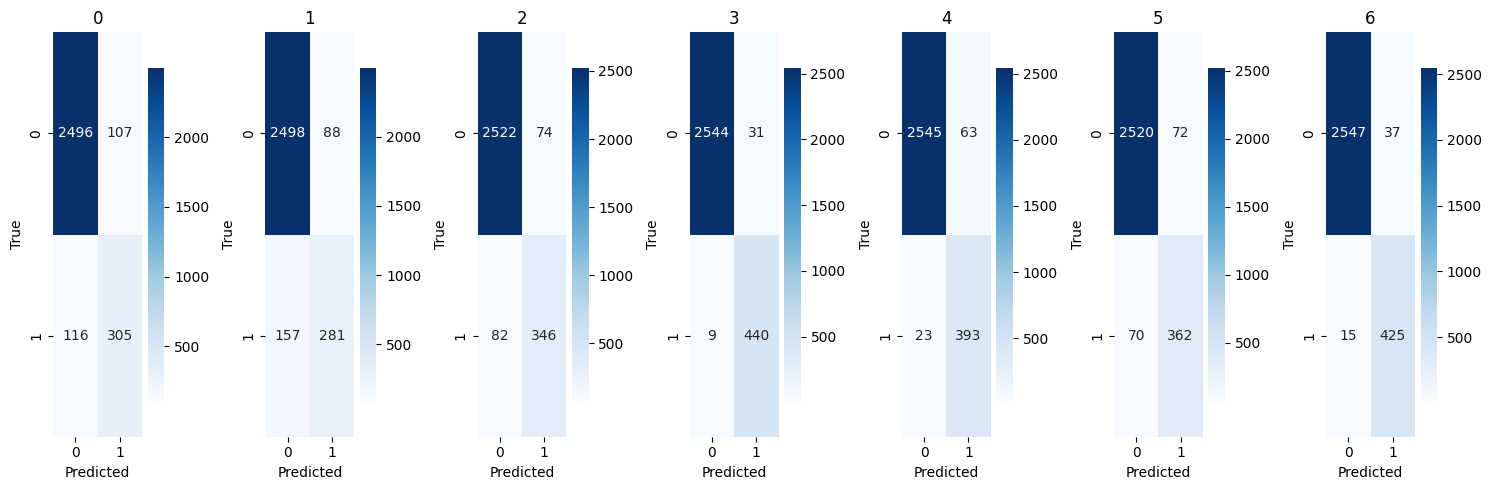

In [86]:
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Crear una figura y un conjunto de subtramas
fig, ax = plt.subplots(nrows=1, ncols=mcm.shape[0], figsize=(15, 5))
labels_fore = np.unique(y_target)
# Dibujar un mapa de calor para cada matriz de confusión
for axes, cm, label in zip(ax.flatten(), mcm,labels_fore ):
    sns.heatmap(cm, annot=True, fmt='d', ax=axes, cmap='Blues')
    axes.set_xlabel('Predicted')
    axes.set_ylabel('True')
    axes.set_title(label)

plt.tight_layout()
plt.savefig(base_path + 'confusion_matrix_forest.png')
plt.show()

Mejores hiperparámetros: {'alpha': 0.04225585641493443, 'colsample_bytree': 0.9994673204837426, 'lambda': 0.1010985106998714, 'learning_rate': 0.12199144745225113, 'max_depth': 8.0, 'n_estimators': 654.0, 'subsample': 0.6884234738887477}